In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
with open('get_movies.pkl', 'rb') as f:
    t = pickle.load(f)
    
movie_dic = t[0]
movie_genre_dic = t[1]

with open('get_ratings.pkl', 'rb') as f:
    lst = pickle.load(f)

In [4]:
def grad_U(Ui, Yij, Vj, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-2*reg*eta)*Ui + 2 * eta * Vj * (Yij - y_mean - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, y_mean, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-2*reg*eta)*Vj + 2 * eta * Ui * (Yij - y_mean - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += reg * (U_frobenius_norm ** 2)
        err += reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def get_msqe_err(U, V, Y):
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    
    err /= len(Y)
    
    return err ** 0.5

def train_model(M, N, K, eta, reg, Y, Y_test):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    
    best_test_error = float('inf')
    
    size = len(Y)
    delta = None
    indices = np.arange(size)    
    epoch = 0

    
    while True:
        epoch += 1
        
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        
        prev_U = U.copy()
        prev_V = V.copy()
        
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], y_mean, reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], y_mean, reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        E_out = get_msqe_err(U, V, Y_test)

        print("Epoch %s, E_in (regularized MSE): %s; E_out (MSQE): %s"%(epoch, E_in, E_out))
#         print("Epoch %s, E_in (regularized MSE): %s; MSQE: %s"%(epoch + 1, E_in, get_msqe_err(U, V, Y)))


        if best_test_error > E_out:
            best_test_error = E_out
        else:
            return (prev_U, prev_V, get_msqe_err(prev_U, prev_V, Y), get_msqe_err(prev_U, prev_V, Y_test), epoch - 1)

#     return (U, V, get_err(U, V, Y,y_mean))
    return -1

In [5]:
ratings = np.array(lst)

# train/test

In [6]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

In [7]:
num_movies = len(movie_dic)
num_users = 943
m = num_users
n = num_movies
k = 20
eta = 0.005
reg = 0.02

# u,v, final_err, y_mean = train_model(m, n, k, eta, reg, Y_train, eps=0.0001, max_epochs=100)

u,v, final_err, final_test_err, epoch = train_model(m, n, k, eta, reg, Y_train, Y_test)

print(final_test_err, epoch)

Epoch 1, E_in (regularized MSE): 1.2828558750425283; E_out (MSQE): 1.1570207958624026
Epoch 2, E_in (regularized MSE): 1.2084898692939399; E_out (MSQE): 1.1451978915028977
Epoch 3, E_in (regularized MSE): 1.1309837519331776; E_out (MSQE): 1.128466523869615
Epoch 4, E_in (regularized MSE): 1.0358591502680812; E_out (MSQE): 1.1033044684433846
Epoch 5, E_in (regularized MSE): 0.9420590181157769; E_out (MSQE): 1.0778830307402227
Epoch 6, E_in (regularized MSE): 0.8600017404041497; E_out (MSQE): 1.0569297452658348
Epoch 7, E_in (regularized MSE): 0.7909564204903258; E_out (MSQE): 1.039725349200197
Epoch 8, E_in (regularized MSE): 0.7357670423472611; E_out (MSQE): 1.0267571892748961
Epoch 9, E_in (regularized MSE): 0.6920910973471952; E_out (MSQE): 1.0173029718272495
Epoch 10, E_in (regularized MSE): 0.6570357666649607; E_out (MSQE): 1.0107726712744614
Epoch 11, E_in (regularized MSE): 0.6276553330895492; E_out (MSQE): 1.0057426606246773
Epoch 12, E_in (regularized MSE): 0.6030125835800789; 

In [7]:
# # e_in = get_err(u, v, Y_train)
# # e_out = get_err(u, v, Y_test)
# e_in = get_msqe_err(u, v, Y_train)
# e_out = get_msqe_err(u, v, Y_test)
# print("e_in is: " + str(e_in))
# print("e_out is: " + str(e_out))

# SVD visualization

In [8]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit_transform(v)
print("done")

done


In [79]:
from numpy.linalg import svd
a, sigma, b = np.linalg.svd(v)

In [9]:
a.shape

(20, 20)

In [10]:
b.shape

(1682, 1682)

In [11]:
np.diag(sigma).shape

(20, 20)

In [12]:
u.shape

(943, 20)

In [13]:
v.shape

(20, 1682)

In [14]:
transformer = a[:, :2].T
print(transformer.shape)

(2, 20)


In [15]:
transformed_v = np.matmul(transformer, v).T
print(transformed_v.shape)

(1682, 2)


In [16]:
transformed_u = np.matmul(transformer, u.T).T
print(transformed_u.shape)

(943, 2)


# visualizations

In [19]:
indices = np.random.randint(1682, size=10)

In [20]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]

Text(0.5, 1.0, 'Top 10 random movies')

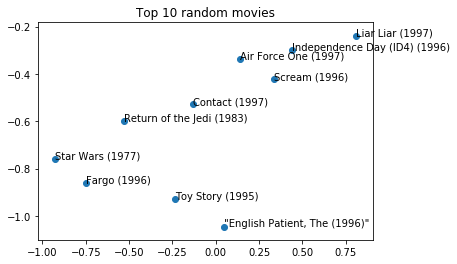

In [83]:
plt.scatter(x,y)
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))
plt.title("Top 10 random movies")

In [80]:
num_ratings_vs_movies = [0 for i in movie_dic.keys()]
for (i, j, yij) in lst:
    num_ratings_vs_movies[j] += 1
num_ratings_vs_movies = np.array(num_ratings_vs_movies)

In [81]:
indices = num_ratings_vs_movies.argsort()[-10:][::-1]

Text(0.5, 1.0, 'Top 10 most rated movies')

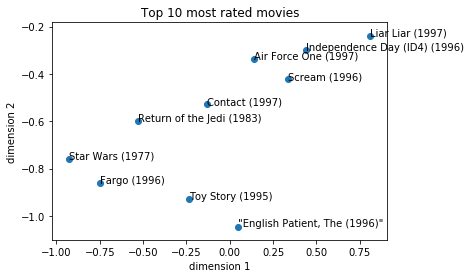

In [82]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))
    
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.title("Top 10 most rated movies")

In [24]:
movie_rating_dic = {id: [] for id in movie_dic.keys()} # dic of movie id and ratings

for rating in lst:
    _, movie_id, r = rating
    movie_rating_dic[movie_id].append(r)

avg_ratings = {movie: sum(movie_rating_dic[movie]) / len(movie_rating_dic[movie]) \
               for movie in movie_rating_dic}

# get ten best movies that received highest average rating
top_10 = sorted(avg_ratings.items(), key=lambda tup: tup[1], reverse=True)[:10]
indices = [t[0] for t in top_10]

Text(0.5, 1.0, 'Top 10 movies with highest average rating')

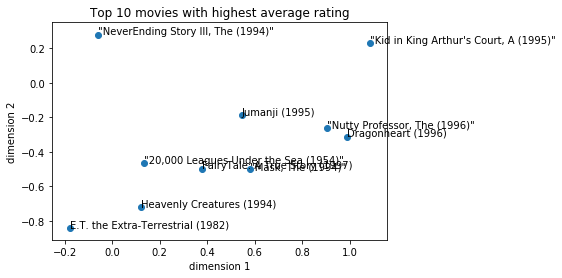

In [68]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))
    
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.title("Top 10 movies with highest average rating")

Text(0.5, 1.0, '10 movies from Fantasy genre')

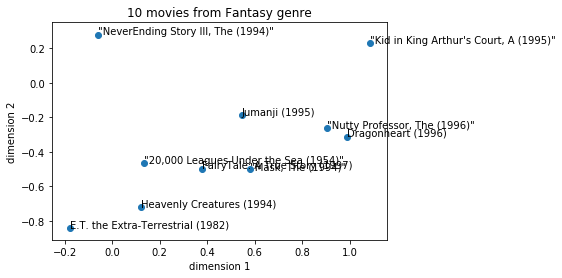

In [69]:
fant_movies = movie_genre_dic['Fantasy']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))
    
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.title("10 movies from Fantasy genre")

[31, 47, 74, 114, 118, 319, 359, 633, 643, 644]


Text(0.5, 1.0, '10 movies from Documentary genre')

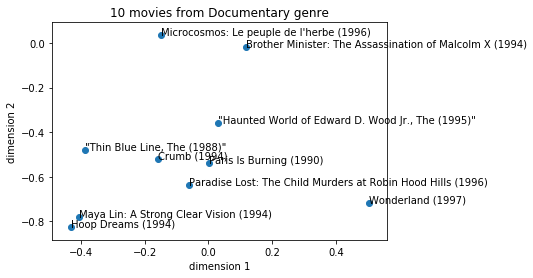

In [70]:
fant_movies = movie_genre_dic['Documentary']
indices = fant_movies[:10]
print(indices)
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))
    
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.title("10 movies from Documentary genre")

Text(0.5, 1.0, "10 movies from Children's genre")

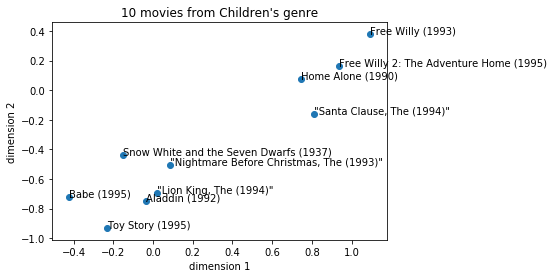

In [71]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(movie_dic[indices[i]], (xi, yi))

plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.title("10 movies from Children's genre")

# creative stuff

Text(0, 0.5, 'dimension 2')

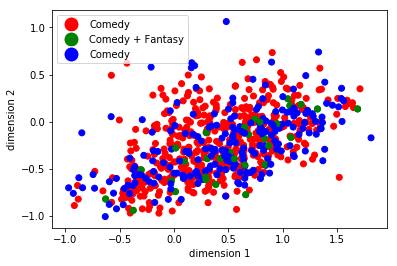

In [58]:
from matplotlib.lines import Line2D
# take two genres, see if the 'both' rated genres are closer to clusters
fant_movies = movie_genre_dic["Action"]
comedy_movies = movie_genre_dic["Comedy"]

x_comedies = [transformed_v[i][0] for i in comedy_movies]
y_comedies = [transformed_v[i][1] for i in comedy_movies]

x_fant = [transformed_v[i][0] for i in fant_movies]
y_fant = [transformed_v[i][1] for i in fant_movies]


colors = []
labels = []
for i in comedy_movies:
    if i not in fant_movies:
        colors.append('r')
        labels.append('Comedy')
    else:
        colors.append('g')
        labels.append('Comedy + Fantasy')
for i in fant_movies:
    if i not in comedy_movies:
        colors.append('b')
        labels.append('Fantasy')
    else:
        colors.append('g')
        labels.append('Comedy + Fantasy')


x = x_comedies + x_fant
y = y_comedies + y_fant

plt.scatter(x,y, c=colors)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Comedy',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Comedy + Fantasy',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Comedy',
                          markerfacecolor='b', markersize=15)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

Text(0, 0.5, 'dimension 2')

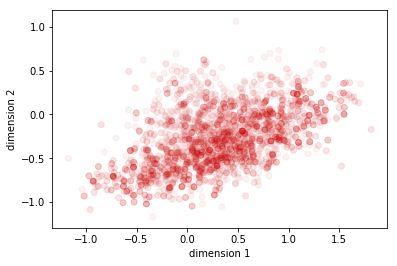

In [60]:
# color all points, make density equal to number of genres the movie is in
# gets informatino about how "generic" a movie is
genre =  ['Unknown', 'Action', 'Adventure', 'Animation',
           "Children's", 'Comedy', 'Crime', 'Documentary',
           'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
           'Thriller', 'War', 'Western']

genre_density = [0 for i in range(len(movie_dic))]
for i in range(len(movie_dic)):
    for g in genre:
        if i in movie_genre_dic[g]:
            genre_density[i] += 1

x = [transformed_v[i][0] for i in range(len(genre_density))]
y = [transformed_v[i][1] for i in range(len(genre_density))]

rgba_colors = np.zeros((len(genre_density),4))
rgba_colors[:,0] = 0.8
densities = []
for i in genre_density:
    if i == 1:
        densities.append(0.05)
    elif i == 2:
        densities.append(0.1)
    elif i == 3:
        densities.append(0.2)
    elif i == 4:
        densities.append(0.3)
    elif i == 5:
        densities.append(0.4)
    elif i == 6:
        densities.append(0.5)
    elif i == 7:
        densities.append(0.6)
    elif i == 8:
        densities.append(0.7)
    elif i == 9:
        densities.append(0.8)
    elif i == 10:
        densities.append(0.9)
    else:
        densities.append(1)

rgba_colors[:, 3] = densities
plt.scatter(x, y, color=rgba_colors)
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

Text(0, 0.5, 'dimension 2')

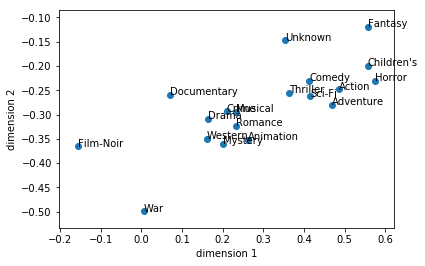

In [61]:
# see how related the genres are in the embedding space
# gets information about the movie genres
centers_x = []
centers_y = []
for g in genre:
    indices = movie_genre_dic[g]
    temp_x = np.array([transformed_v[i][0] for i in indices])
    temp_y = np.array([transformed_v[i][1] for i in indices])
    
    centers_x.append(np.mean(temp_x))
    centers_y.append(np.mean(temp_y))
    
plt.scatter(centers_x,centers_y)
for i, (xi, yi) in enumerate(zip(centers_x, centers_y)):
    plt.annotate(genre[i], (xi, yi))

plt.xlabel("dimension 1")
plt.ylabel("dimension 2")

Text(0, 0.5, 'dimension 2')

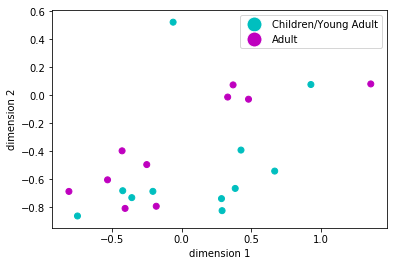

In [74]:
# compare age groups

children_indices = [99, 132, 420, 1, 383, 398, 380, 427, 207, 231, 1442]
adult_indices = [156, 177, 179, 318, 902, 29, 405, 852, 219, 82]
indices = children_indices + adult_indices

x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]



colors = []
for i in children_indices:
    colors.append('c')
    
for i in adult_indices:
    colors.append('m')


plt.scatter(x,y, c=colors)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Children/Young Adult',
                          markerfacecolor='c', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Adult',
                          markerfacecolor='m', markersize=15)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")


Text(0, 0.5, 'dimension 2')

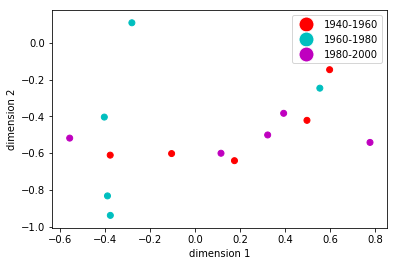

In [78]:
# movies style change over time, so we take a few samples from different time periods and 
# try to see how well the embeddings capture these cultural differences in time periods

period_1 = [968, 1020, 1050, 1064, 1116]
period_2 = [945, 1123, 429, 434, 488]
period_3 = [951, 2, 22, 64, 67]

indices = period_1 + period_2 + period_3

x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]



colors = []
for i in period_1:
    colors.append('r')
    
for i in period_2:
    colors.append('c')

for i in period_3:
    colors.append('m')

plt.scatter(x,y, c=colors)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='1940-1960',
                          markerfacecolor='r', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='1960-1980',
                          markerfacecolor='c', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='1980-2000',
                          markerfacecolor='m', markersize=15)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("dimension 1")
plt.ylabel("dimension 2")